In [2]:
! rm -rf space-model
! git clone -b explanation/token-attention https: // github.com/StepanTita/space-model.git
# ! git clone https://github.com/jayded/eraserbenchmark.git

Cloning into 'space-model'...
remote: Enumerating objects: 196, done.
remote: Counting objects: 100% (196/196), done.
remote: Compressing objects: 100% (161/161), done.
remote: Total 196 (delta 64), reused 161 (delta 32), pack-reused 0
Receiving objects: 100% (196/196), 32.12 MiB | 23.05 MiB/s, done.
Resolving deltas: 100% (64/64), done.


In [1]:
# dowload data archive to data folder using wget
! wget -P data/https://www.eraserbenchmark.com/zipped/boolq.tar.gz
! wget -P data/https://www.eraserbenchmark.com/zipped/multirc.tar.gz
! wget -P data/https://www.eraserbenchmark.com/zipped/esnli.tar.gz
! wget -P data/https://www.eraserbenchmark.com/zipped/cose.tar.gz
! wget -P data/https://www.eraserbenchmark.com/zipped/fever.tar.gz
! wget -P data/https://www.eraserbenchmark.com/zipped/evidence_inference.tar.gz
! wget -P data/https://storage.googleapis.com/sfr-nazneen-website-files-research/scifact.tar.gz
! wget -P data/https://www.eraserbenchmark.com/zipped/movies.tar.gz

--2024-03-12 01:07:51--  https://www.eraserbenchmark.com/zipped/movies.tar.gz
Resolving www.eraserbenchmark.com (www.eraserbenchmark.com)... 52.202.168.65, 18.205.222.128, 54.161.241.46, ...
Connecting to www.eraserbenchmark.com (www.eraserbenchmark.com)|52.202.168.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3899487 (3.7M) [application/gzip]
Saving to: ‘data/movies.tar.gz’

movies.tar.gz       100%[===================>]   3.72M  15.9MB/s    in 0.2s    

2024-03-12 01:07:51 (15.9 MB/s) - ‘data/movies.tar.gz’ saved [3899487/3899487]



In [2]:
# extract data archives
! tar -xvf data/boolq.tar.gz -C data/
! tar -xvf data/multirc.tar.gz -C data/
! tar -xvf data/esnli.tar.gz -C data/
! tar -xvf data/cose.tar.gz -C data/
! tar -xvf data/fever.tar.gz -C data/
! tar -xvf data/evidence_inference.tar.gz -C data/
! tar -xvf data/scifact.tar.gz -C data/
! tar -xvf data/movies.tar.gz -C data/

movies/
movies/movies_union_human_perf.jsonl
movies/docs/
movies/docs/negR_912.txt
movies/docs/posR_632.txt
movies/docs/posR_270.txt
movies/docs/posR_627.txt
movies/docs/posR_892.txt
movies/docs/negR_709.txt
movies/docs/negR_427.txt
movies/docs/negR_821.txt
movies/docs/negR_193.txt
movies/docs/negR_665.txt
movies/docs/negR_315.txt
movies/docs/posR_029.txt
movies/docs/negR_370.txt
movies/docs/posR_280.txt
movies/docs/negR_380.txt
movies/docs/negR_694.txt
movies/docs/posR_722.txt
movies/docs/posR_764.txt
movies/docs/negR_572.txt
movies/docs/posR_851.txt
movies/docs/negR_210.txt
movies/docs/negR_741.txt
movies/docs/posR_331.txt
movies/docs/posR_355.txt
movies/docs/negR_682.txt
movies/docs/posR_457.txt
movies/docs/negR_575.txt
movies/docs/negR_437.txt
movies/docs/negR_534.txt
movies/docs/negR_179.txt
movies/docs/negR_764.txt
movies/docs/negR_746.txt
movies/docs/posR_197.txt
movies/docs/negR_926.txt
movies/docs/negR_394.txt
movies/docs/negR_726.txt
movies/docs/posR_705.txt
movies/docs/negR_

## TODO:
- Train BERT on all of the rationalized datasets

In [1]:
import sys

sys.path.append('space-model')

In [2]:
import os
import random

from collections import Counter

import numpy as np

import torch
import torch.nn.functional as F

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, jaccard_score

from tqdm import tqdm

from transformers import AutoModel, AutoTokenizer
from transformers import get_linear_schedule_with_warmup

from datasets import load_dataset

from space_model.model import *
from space_model.loss import *

from logger import get_logger, log_continue
from train import train, eval, plot_results, concept_space_to_preds
from utils import free_resources_deco

2024-04-28 16:48:22.225940: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-28 16:48:22.230183: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-28 16:48:22.285281: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [4]:
SEED = 42

In [5]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(seed=SEED)

In [6]:
def on_gpu(f):
    def wrapper(*args):
        if torch.cuda.is_available():
            return f(*args)
        else:
            print('cuda unavailable')

    return wrapper

In [7]:
if torch.cuda.is_available():
    ! pip install pynvml
    from pynvml import *


@on_gpu
def print_gpu_utilization(dev_id):
    try:
        nvmlInit()
        handle = nvmlDeviceGetHandleByIndex(dev_id)
        info = nvmlDeviceGetMemoryInfo(handle)
        print(f"GPU memory occupied: {info.used // 1024 ** 2} MB.")
    except Exception as e:
        print(e)


@on_gpu
def free_gpu_cache(dev_id=0):
    print("Initial GPU Usage")
    print_gpu_utilization(dev_id)

    torch.cuda.empty_cache()

    print("GPU Usage after emptying the cache")
    print_gpu_utilization(dev_id)


def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()

In [8]:
device_id = 0

In [9]:
device = torch.device(f'cuda:{device_id}' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [10]:
if torch.cuda.is_available():
    torch.cuda.set_device(device)

In [12]:
MODEL_NAME = 'bert-base-uncased'

DATASET_NAME = 'hatexplain'

NUM_LABELS = 3
N_LATENT = 128

NUM_EPOCHS = 1
BATCH_SIZE = 16
MAX_SEQ_LEN = 512
LEARNING_RATE = 2e-5
MAX_GRAD_NORM = 1000

In [13]:
def get_label(annotators):
    # get the most common label using simple voting and accounting for batching
    return [Counter(anno['label']).most_common(1)[0][0] for anno in annotators]

def encode_label(labels):
    if label == 'hatespeech':
        return 0
    elif label == 'normal':
        return 1
    elif label == 'offensive':
        return 2
    else:
        raise Exception(f'Unknown Label: {label}!')

In [14]:
dataset = load_dataset(DATASET_NAME).filter(lambda example: len(example['rationales']) > 0)
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'annotators', 'rationales', 'post_tokens'],
        num_rows: 9132
    })
    validation: Dataset({
        features: ['id', 'annotators', 'rationales', 'post_tokens'],
        num_rows: 1141
    })
    test: Dataset({
        features: ['id', 'annotators', 'rationales', 'post_tokens'],
        num_rows: 1142
    })
})

In [15]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer

BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [16]:
def rationales_union(examples):
    res = []
    for ex in examples:
        rational = np.array([0] * len(ex[0]))
        for r in ex:
            common_len = max(len(rational), len(r))
            # pad rationales to the same length
            rational = np.pad(rational, (0, common_len - len(rational)))
            r = np.pad(r, (0, common_len - len(r)))
            rational = rational | r
        res.append(rational.tolist())
    return res

In [17]:
dataset = dataset.map(lambda x: {'label': get_label(x['annotators'])}, num_proc=4, batched=True)
dataset = dataset.map(lambda x: {'rational': rationales_union(x['rationales'])}, num_proc=4, batched=True)
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'annotators', 'rationales', 'post_tokens', 'label', 'rational'],
        num_rows: 9132
    })
    validation: Dataset({
        features: ['id', 'annotators', 'rationales', 'post_tokens', 'label', 'rational'],
        num_rows: 1141
    })
    test: Dataset({
        features: ['id', 'annotators', 'rationales', 'post_tokens', 'label', 'rational'],
        num_rows: 1142
    })
})

In [18]:
def exp_distribute(rational, tau=1.0):
    rational = torch.tensor(rational)
    indices = torch.arange(len(rational))
    mask = rational == 1
    res = torch.zeros_like(rational).float()
    res[mask] = 1
    res += torch.sum(1 / torch.exp(torch.abs(indices[mask].unsqueeze(-1) - indices)) * tau, dim=0)
    res = torch.softmax(res, dim=0)
    return res


def exp_distribute_batched(rational, tau=1.0):
    res = []
    for r in rational:
        res.append(exp_distribute(r, tau))
    return torch.stack(res)

In [19]:
exp_distribute([0, 0, 0, 1, 0, 0, 1, 0, 0, 0], tau=8.0)

tensor([6.2513e-05, 1.2823e-04, 9.0398e-04, 4.9660e-01, 2.3053e-03, 2.3053e-03,
        4.9660e-01, 9.0398e-04, 1.2823e-04, 6.2513e-05])

In [20]:
# tokenize post_tokens accounting for the rationales
def tokenize_rationales(examples, tokenizer, max_seq_length, start_sym='##', tau=1.0):
    input_ids = []
    token_type_ids = []
    attention_mask = []
    hard_rationales = []
    soft_rationales = []
    for text, r, label in zip(examples['post_tokens'], examples['rational'], examples['label']):
        tokens = []
        rationale = []
        for i, t in enumerate(text):
            sub_words = tokenizer.tokenize(t)
            tokens.extend(sub_words)
            rationale.extend([r[i]] * len(sub_words))

        tokens = tokens[:max_seq_length - 2]
        rationale = rationale[:max_seq_length - 2]

        seq_len = len(tokens) + 2
        tokens = ['[CLS]'] + tokens + ['[SEP]'] + ['[PAD]'] * (max_seq_length - len(tokens) - 2)

        ids = tokenizer.convert_tokens_to_ids(tokens)
        token_types = [0] * len(ids)
        attn = [1] * seq_len + [0] * (max_seq_length - seq_len)
        rational = rationale + [0] * (max_seq_length - len(rationale))

        assert len(ids) == max_seq_length, f'Ids {len(ids)} != {max_seq_length}'
        assert len(token_types) == max_seq_length, f'Token Types {len(token_types)} != {max_seq_length}'
        assert len(attn) == max_seq_length, f'Attention Mask {len(attn)} != {max_seq_length}'
        assert len(rational) == max_seq_length, f'Rational {len(rational)} != {max_seq_length}'

        input_ids.append(ids)
        token_type_ids.append(token_types)
        attention_mask.append(attn)
        hard_rationales.append(rational)

        if label != 1:
            soft_rationales.append(exp_distribute(rational, tau=tau))
        else:
            soft_rationales.append(torch.tensor([1 / max_seq_length for _ in range(max_seq_length)]))

    tokenized_examples = {}
    tokenized_examples['input_ids'] = torch.tensor(input_ids)
    tokenized_examples['rationaled'] = torch.tensor(hard_rationales)
    tokenized_examples['token_type_ids'] = torch.tensor(token_type_ids)
    tokenized_examples['attention_mask'] = torch.tensor(attention_mask)
    tokenized_examples['soft_rationales'] = torch.stack(soft_rationales)

    return tokenized_examples

In [21]:
tokenize_rationales({
    'post_tokens': ['Notes : we should actually compare this with S - BERT . For now we just use Mean of BERT embeddings as a centroid'.split(' ')],
    'rational': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1]],
    'label': [2]
}, tokenizer, MAX_SEQ_LEN, tau=1.0)

{'input_ids': tensor([[  101,  3964,  1024,  2057,  2323,  2941, 12826,  2023,  2007,  1055,
           1011, 14324,  1012,  2005,  2085,  2057,  2074,  2224,  2812,  1997,
          14324,  7861,  8270,  4667,  2015,  2004,  1037, 18120,  3593,   102,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,    

In [22]:
tokenized_dataset = dataset.map(lambda x: tokenize_rationales(x, tokenizer, MAX_SEQ_LEN, tau=6.0), num_proc=1,
                                batched=True).remove_columns(
    ['post_tokens', 'rational', 'rationales', 'annotators'])
tokenized_dataset.set_format('torch', device=device)
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'label', 'input_ids', 'rationaled', 'token_type_ids', 'attention_mask', 'soft_rationales'],
        num_rows: 9132
    })
    validation: Dataset({
        features: ['id', 'label', 'input_ids', 'rationaled', 'token_type_ids', 'attention_mask', 'soft_rationales'],
        num_rows: 1141
    })
    test: Dataset({
        features: ['id', 'label', 'input_ids', 'rationaled', 'token_type_ids', 'attention_mask', 'soft_rationales'],
        num_rows: 1142
    })
})

In [23]:
class BERTOutputs:
    def __init__(self, loss, logits, hidden_states, attentions):
        self.loss = loss
        self.logits = logits
        self.hidden_states = hidden_states
        self.attentions = attentions


class BERTwithRationalLossForSequenceClassification(torch.nn.Module):
    def __init__(self, model, rational_weight=0.5, ce_weight=1.0):
        super(BERTwithRationalLossForSequenceClassification, self).__init__()
        self.model = model

        self.ce_weight = ce_weight
        self.rational_weight = rational_weight

        self.classifier = torch.nn.Linear(model.config.hidden_size, model.config.num_labels)

    def to(self, device):
        super().to(device)
        self.device = device
        self.model.to(device)
        return self

    def forward(self, input_ids, attention_mask, labels, hard_rationales, soft_rationales):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)

        hidden_states = outputs.hidden_states
        last_hidden_state = hidden_states[-1]  # (B, seq_len, n_embed)

        # Rationale Loss
        attentions = outputs.attentions[-1]  # (B, n_heads, seq_len, seq_len)

        n_heads = self.model.config.num_attention_heads

        # Iterate over each head
        rationale_loss = 0.0

        for h in range(n_heads):
            att = torch.clip(attentions[:, h, 0, :], 0.0, 1.0)  # (B, seq_len)

            rationale_loss += F.binary_cross_entropy(att, soft_rationales)

        # Mean Rationale Loss of each attention head
        rationale_loss = rationale_loss / n_heads

        # END Rationale Loss

        logits = self.classifier(last_hidden_state)[:, 0, :]

        ce_loss = F.cross_entropy(logits, labels)

        loss = self.ce_weight * ce_loss + self.rational_weight * rationale_loss

        return BERTOutputs(loss, logits, hidden_states, attentions)

In [24]:
body_bert = AutoModel.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS, output_hidden_states=True,
                                      output_attentions=True).to(device)
raw_model = BERTwithRationalLossForSequenceClassification(body_bert, rational_weight=1.0, ce_weight=1.0).to(device)
raw_model

BERTwithRationalLossForSequenceClassification(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((

In [25]:
# raw_model.load_state_dict(torch.load(f'models/{DATASET_NAME}_{MODEL_NAME}_{NUM_EPOCHS}.bin'))

In [26]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [27]:
# for p in raw_model.bert.parameters():
#     p.requires_grad = True
# for p in raw_model.distilbert.parameters():
#     p.requires_grad = False

In [28]:
count_parameters(raw_model)

109484547

In [29]:
def get_preds_from_logits(outputs):
    assert torch.any(torch.isfinite(outputs.logits)), 'Logits contain infinite values!'

    probs = F.softmax(outputs.logits, dim=-1).cpu()
    pred = torch.argmax(probs, dim=-1)  # (B)
    return outputs.loss, pred.long(), outputs.logits

In [30]:
def bert_outputs_callback(outputs):
    return outputs.attentions.mean(dim=1)[:, 0, :]

In [31]:
import numpy as np

data = np.array([0.5, 0.7, 1.0, 1.2, 1.3, 2.1])
hist, bin_edges = np.histogram(data, bins=3)

print("Histogram:", hist)
print("Bin Edges:", bin_edges)

Histogram: [3 2 1]
Bin Edges: [0.5        1.03333333 1.56666667 2.1       ]


In [32]:
def build_hist(soft_rationales):
    bins = np.linspace(0, 1, 11)
    hist = np.zeros(10)
    for r in soft_rationales:
        hist += np.histogram(r, bins=bins)[0]
    return hist

In [33]:
@train
def train_epoch(model, train_dataloader, optimizer, scheduler, config):
    train_loss = 0.0
    train_preds = []
    cs_train_preds = []
    train_labels = []
    train_rational_preds = []
    train_rational = []
    train_soft_recall = []
    train_soft_precision = []

    for step, batch in enumerate(tqdm(train_dataloader, total=len(train_dataloader))):
        ids = batch['input_ids'].to(model.device, dtype=torch.long)
        mask = batch['attention_mask'].to(model.device, dtype=torch.long)
        targets = batch['label'].to(model.device, dtype=torch.long)
        hard_rationale = batch['rationaled'].to(device, dtype=torch.long)
        soft_rationale = batch['soft_rationales'].to(device, dtype=torch.float)

        outputs = model(input_ids=ids, attention_mask=mask, labels=targets,
                        hard_rationales=hard_rationale, soft_rationales=soft_rationale)  # (B, Seq_Len, 2)

        loss, pred, logits = config['preds_from_logits_func'](outputs)

        train_preds += pred.detach().tolist()
        train_labels += targets.cpu().tolist()

        # Rationale Prediction

        hard_rationale = hard_rationale.cpu()
        soft_rationale = soft_rationale.cpu()

        pred_rationale = config['model_outputs_callback'](outputs).detach().cpu()
        pred_hard_rationale = (pred_rationale > config['threshold']).long()
        pred_soft_rationale = exp_distribute_batched(pred_hard_rationale)

        train_soft_recall += (pred_hard_rationale * soft_rationale).sum(
            dim=1).tolist()  # this should give us the match score for each example (0, 1)
        train_soft_precision += (F.softmax(pred_soft_rationale, dim=-1) * hard_rationale).sum(
            dim=1).tolist()  # this should give us the match score for each example (0, 1)

        train_rational_preds += pred_hard_rationale.tolist()
        train_rational += hard_rationale.cpu().tolist()

        ### Distance Based Classification
        # out.concept_spaces (n, B, seq_len, n_latent)
        if hasattr(outputs, 'concept_spaces'):
            preds = concept_space_to_preds(outputs.concept_spaces)

            # multi-label classification
            if len(targets.shape) > 1:
                # turn preds into one-hot
                preds = F.one_hot(torch.tensor(preds), len(outputs.concept_spaces))
            cs_train_preds += preds
        ### END

        if (step + 1) % config['gradient_accumulation_steps'] == 0:
            optimizer.zero_grad()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), config['max_grad_norm'])

            optimizer.step()
            scheduler.step()

        batch_loss = loss.item()
        if config['gradient_accumulation_steps'] > 1:
            batch_loss = batch_loss / config['gradient_accumulation_steps']

        train_loss += batch_loss
    return {
        'loss': train_loss,
        'preds': train_preds,
        'labels': train_labels,
        'cs_preds': cs_train_preds,
        'rational_preds': train_rational_preds,
        'rational': train_rational,
        'soft_rational_recall': train_soft_recall,
        'soft_rational_precision': train_soft_precision
    }


@eval
def eval_epoch(model, val_dataloader, config):
    val_loss = 0.0
    val_preds = []
    cs_val_preds = []
    val_labels = []
    val_rational_preds = []
    val_rational = []
    val_soft_recall = []
    val_soft_precision = []

    with torch.no_grad():

        for step, batch in enumerate(tqdm(val_dataloader, total=len(val_dataloader))):
            ids = batch['input_ids'].to(model.device, dtype=torch.long)
            mask = batch['attention_mask'].to(model.device, dtype=torch.long)
            targets = batch['label'].to(model.device, dtype=torch.long)
            hard_rationale = batch['rationaled'].to(device, dtype=torch.long)
            soft_rationale = batch['soft_rationales'].to(device, dtype=torch.float)

            outputs = model(input_ids=ids, attention_mask=mask, labels=targets,
                            hard_rationales=hard_rationale, soft_rationales=soft_rationale)  # (B, Seq_Len, 2)

            loss, pred, logits = config['preds_from_logits_func'](outputs)

            val_preds += pred.detach().tolist()
            val_labels += targets.cpu().tolist()

            # Rationale Prediction

            hard_rationale = hard_rationale.cpu()
            soft_rationale = soft_rationale.cpu()

            pred_rationale = config['model_outputs_callback'](outputs).detach().cpu()
            pred_hard_rationale = (pred_rationale > config['threshold']).long()
            pred_soft_rationale = exp_distribute_batched(pred_hard_rationale)

            val_soft_recall += (pred_hard_rationale * soft_rationale).sum(
                dim=1).tolist()  # this should give us the match score for each example (0, 1)
            val_soft_precision += (F.softmax(pred_soft_rationale, dim=-1) * hard_rationale).sum(
                dim=1).tolist()  # this should give us the match score for each example (0, 1)

            val_rational_preds += pred_hard_rationale.tolist()
            val_rational += hard_rationale.cpu().tolist()

            ### Distance Based Classification
            # out.concept_spaces (n, B, seq_len, n_latent)
            if hasattr(outputs, 'concept_spaces'):
                preds = concept_space_to_preds(outputs.concept_spaces)

                # multi-label classification
                if len(targets.shape) > 1:
                    # turn preds into one-hot
                    preds = F.one_hot(torch.tensor(preds), len(outputs.concept_spaces))
                cs_val_preds += preds
            ### END

            val_loss += loss.item()
    return {
        'loss': val_loss,
        'preds': val_preds,
        'labels': val_labels,
        'cs_preds': cs_val_preds,
        'rational_preds': val_rational_preds,
        'rational': val_rational,
        'soft_rational_recall': val_soft_recall,
        'soft_rational_precision': val_soft_precision
    }


@free_resources_deco
def training(model, train_data, val_data, log, config):
    optimizer = torch.optim.AdamW(
        params=model.parameters(),
        lr=config['lr'],
        weight_decay=config['weight_decay']
    )

    num_train_steps = int(len(train_data) / config['batch_size'] * config['num_epochs'])
    steps_per_epoch = len(train_data) / config['batch_size']

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=config['num_warmup_steps'],
        num_training_steps=num_train_steps,
    )

    log.debug(f'Train steps: {num_train_steps}', terminal=config['log_terminal'])
    log.debug(f'Steps per epoch: {steps_per_epoch}', terminal=config['log_terminal'])

    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=config['batch_size'], shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=config['batch_size'])

    history = {
        'train_losses': [],
        'val_losses': [],
        'train_acc': [],
        'val_acc': [],
        'cs_train_acc': [],
        'cs_val_acc': [],
        'train_f1': [],
        'val_f1': [],
        'cs_train_f1': [],
        'cs_val_f1': [],
        'train_precision': [],
        'val_precision': [],
        'train_recall': [],
        'val_recall': [],

        'train_rational_jaccard': [],
        'val_rational_jaccard': [],
        'train_rational_accuracy': [],
        'val_rational_accuracy': [],
        'train_rational_f1': [],
        'val_rational_f1': [],

        'train_rational_precision': [],
        'val_rational_precision': [],
        'train_rational_recall': [],
        'val_rational_recall': [],

        'train_soft_rational_recall': [],
        'val_soft_rational_recall': [],
        'train_soft_rational_precision': [],
        'val_soft_rational_precision': [],
    }

    for epoch_num in range(config['num_epochs']):
        log.info(f'Epoch: {epoch_num + 1}', terminal=config['log_terminal'])

        # train stage
        train_results = train_epoch(model, train_dataloader, optimizer, scheduler, config)
        # eval stage
        val_results = eval_epoch(model, val_dataloader, config)

        train_loss = train_results['loss']
        val_loss = val_results['loss']

        train_preds = train_results['preds']
        cs_train_preds = train_results['cs_preds']
        val_preds = val_results['preds']
        cs_val_preds = val_results['cs_preds']

        train_labels = train_results['labels']
        val_labels = val_results['labels']

        train_rational_preds = train_results['rational_preds']
        val_rational_preds = val_results['rational_preds']

        train_rational = train_results['rational']
        val_rational = val_results['rational']

        train_soft_recall = train_results['soft_rational_recall']
        val_soft_recall = val_results['soft_rational_recall']

        train_soft_precision = train_results['soft_rational_precision']
        val_soft_precision = val_results['soft_rational_precision']

        # metrics
        if len(cs_train_preds) != 0:
            cs_train_acc = accuracy_score(train_labels, cs_train_preds)
            cs_val_acc = accuracy_score(val_labels, cs_val_preds)

            cs_train_f1 = f1_score(train_labels, cs_train_preds, average='macro')
            cs_val_f1 = f1_score(val_labels, cs_val_preds, average='macro')

            history['cs_train_acc'].append(cs_train_acc)
            history['cs_val_acc'].append(cs_val_acc)

            history['cs_train_f1'].append(cs_train_acc)
            history['cs_val_f1'].append(cs_val_acc)

        train_acc = accuracy_score(train_labels, train_preds)
        val_acc = accuracy_score(val_labels, val_preds)
        train_f1 = f1_score(train_labels, train_preds, average='macro')
        val_f1 = f1_score(val_labels, val_preds, average='macro')
        train_precision = precision_score(train_labels, train_preds, average='macro')
        val_precision = precision_score(val_labels, val_preds, average='macro')
        train_recall = recall_score(train_labels, train_preds, average='macro')
        val_recall = recall_score(val_labels, val_preds, average='macro')

        train_rational_jaccard = jaccard_score(train_rational, train_rational_preds, average='macro')
        val_rational_jaccard = jaccard_score(val_rational, val_rational_preds, average='macro')

        train_rational_accuracy = f1_score(train_rational, train_rational_preds, average='micro')
        val_rational_accuracy = f1_score(val_rational, val_rational_preds, average='micro')

        train_rational_f1 = f1_score(train_rational, train_rational_preds, average='macro')
        val_rational_f1 = f1_score(val_rational, val_rational_preds, average='macro')

        train_rational_precision = precision_score(train_rational, train_rational_preds, average='macro')
        val_rational_precision = precision_score(val_rational, val_rational_preds, average='macro')

        train_rational_recall = recall_score(train_rational, train_rational_preds, average='macro')
        val_rational_recall = recall_score(val_rational, val_rational_preds, average='macro')

        train_soft_rational_recall = build_hist(train_soft_recall)
        val_soft_rational_recall = build_hist(val_soft_recall)

        train_soft_rational_precision = build_hist(train_soft_precision)
        val_soft_rational_precision = build_hist(val_soft_precision)

        history['train_losses'].append(train_loss / len(train_dataloader))
        history['val_losses'].append(val_loss / len(val_dataloader))

        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        history['train_f1'].append(train_f1)
        history['val_f1'].append(val_f1)

        history['train_precision'].append(train_precision)
        history['val_precision'].append(val_precision)

        history['train_recall'].append(train_recall)
        history['val_recall'].append(val_recall)

        history['train_rational_jaccard'].append(train_rational_jaccard)
        history['val_rational_jaccard'].append(val_rational_jaccard)

        history['train_rational_accuracy'].append(train_rational_accuracy)
        history['val_rational_accuracy'].append(val_rational_accuracy)

        history['train_rational_f1'].append(train_rational_f1)
        history['val_rational_f1'].append(val_rational_f1)

        history['train_rational_precision'].append(train_rational_precision)
        history['val_rational_precision'].append(val_rational_precision)

        history['train_rational_recall'].append(train_rational_recall)
        history['val_rational_recall'].append(val_rational_recall)

        history['train_soft_rational_precision'].append(train_soft_rational_precision)
        history['val_soft_rational_precision'].append(val_soft_rational_precision)

        history['train_soft_rational_recall'].append(train_soft_rational_recall)
        history['val_soft_rational_recall'].append(val_soft_rational_recall)

        log.info(terminal=config['log_terminal'])
        log.info(f'Train loss: {train_loss / len(train_dataloader)} | Val loss: {val_loss / len(val_dataloader)}',
                 terminal=config['log_terminal'])
        log.info(f'Train acc: {train_acc} | Val acc: {val_acc}', terminal=config['log_terminal'])

        if len(cs_train_preds) != 0:
            log.info(f'CS Train acc: {cs_train_acc} | CS Val acc: {cs_val_acc}', terminal=config['log_terminal'])

        log.info(f'Train f1: {train_f1} | Val f1: {val_f1}', terminal=config['log_terminal'])

        if len(cs_train_preds) != 0:
            log.info(f'CS Train f1: {cs_train_f1} | CS Val f1: {cs_val_f1}', terminal=config['log_terminal'])

        log.info(f'Train precision: {train_precision} | Val precision: {val_precision}',
                 terminal=config['log_terminal'])
        log.info(f'Train recall: {train_recall} | Val recall: {val_recall}', terminal=config['log_terminal'])

        log.info(f'Train rational jaccard: {train_rational_jaccard} | Val rational jaccard: {val_rational_jaccard}',
                 terminal=config['log_terminal'])
        log.info(f'Train rational accuracy: {train_rational_accuracy} | Val rational accuracy: {val_rational_accuracy}',
                 terminal=config['log_terminal'])
        log.info(f'Train rational f1: {train_rational_f1} | Val rational f1: {val_rational_f1}',
                 terminal=config['log_terminal'])
        log.info(
            f'Train rational precision: {train_rational_precision} | Val rational precision: {val_rational_precision}',
            terminal=config['log_terminal'])
        log.info(f'Train rational recall: {train_rational_recall} | Val rational recall: {val_rational_recall}',
                 terminal=config['log_terminal'])

        log.info(
            f'Train soft rational precision: {train_soft_rational_precision} | Val soft rational precision: {val_soft_rational_precision}',
            terminal=config['log_terminal'])
        log.info(
            f'Train soft rational recall: {train_soft_rational_recall} | Val soft rational recall: {val_soft_rational_recall}',
            terminal=config['log_terminal'])

    return history

In [34]:
config = {
    'experiment_name': 'default',
    'log_terminal': True,

    'dataset_name': DATASET_NAME,
    'model_name': MODEL_NAME,

    'num_labels': NUM_LABELS,
    'num_epochs': NUM_EPOCHS,
    'iterations': 1,

    'max_seq_len': MAX_SEQ_LEN,
    'batch_size': BATCH_SIZE,
    'lr': LEARNING_RATE,
    'fp16': False,
    'max_grad_norm': MAX_GRAD_NORM,
    'weight_decay': 0.01,
    'num_warmup_steps': 0,
    'gradient_accumulation_steps': 1,

    'threshold': 0.1,

    # funcs:
    'preds_from_logits_func': get_preds_from_logits,
    'model_outputs_callback': bert_outputs_callback,
}

In [35]:
base_name = f'{DATASET_NAME}-{MODEL_NAME.replace("/", "_")}-{NUM_EPOCHS}'
base_name

'hatexplain-bert-base-uncased-1'

In [36]:
log = get_logger(f'logs/{config["experiment_name"]}', base_name)

In [37]:
base_history = training(raw_model, tokenized_dataset['train'], tokenized_dataset['validation'], log, config)

2024-04-28 16:48:41,659 - default.terminal - DEBUG - Train steps: 570
2024-04-28 16:48:41,661 - default.terminal - DEBUG - Steps per epoch: 570.75
2024-04-28 16:48:41,662 - default.terminal - INFO - Epoch: 1
  0%|          | 0/571 [00:00<?, ?it/s]/var/tmp/ipykernel_10983/1785337210.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rational = torch.tensor(rational)
100%|██████████| 72/72 [00:11<00:00,  6.54it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Jaccard is ill-define

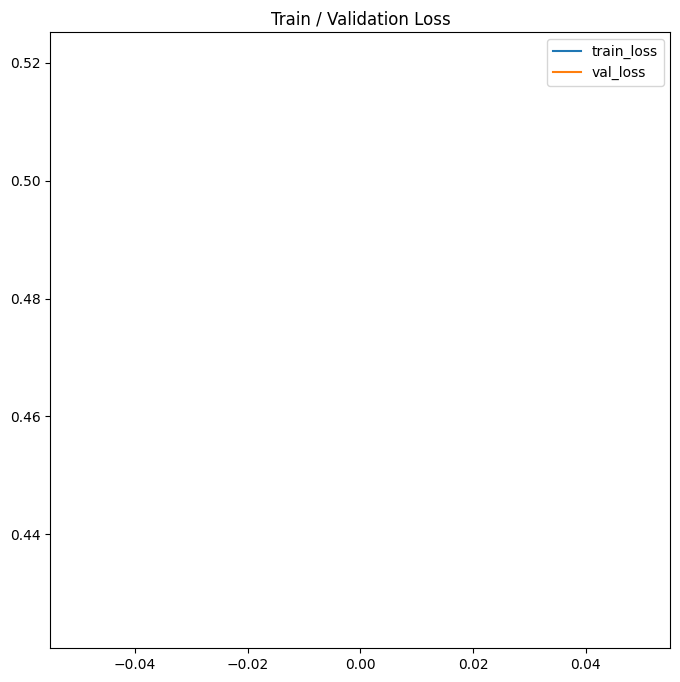

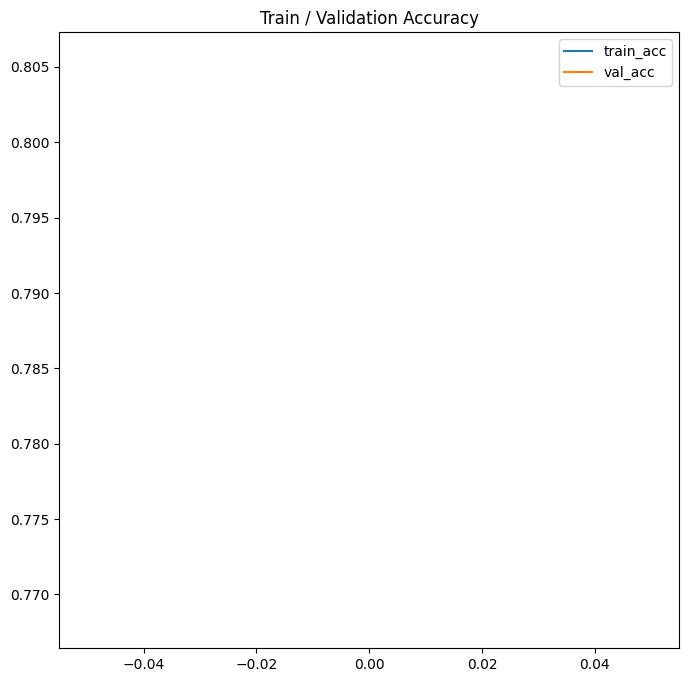

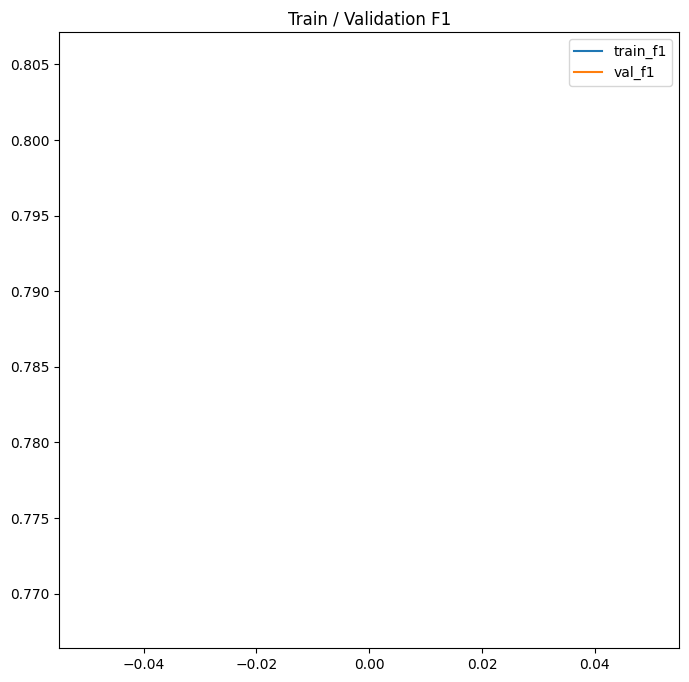

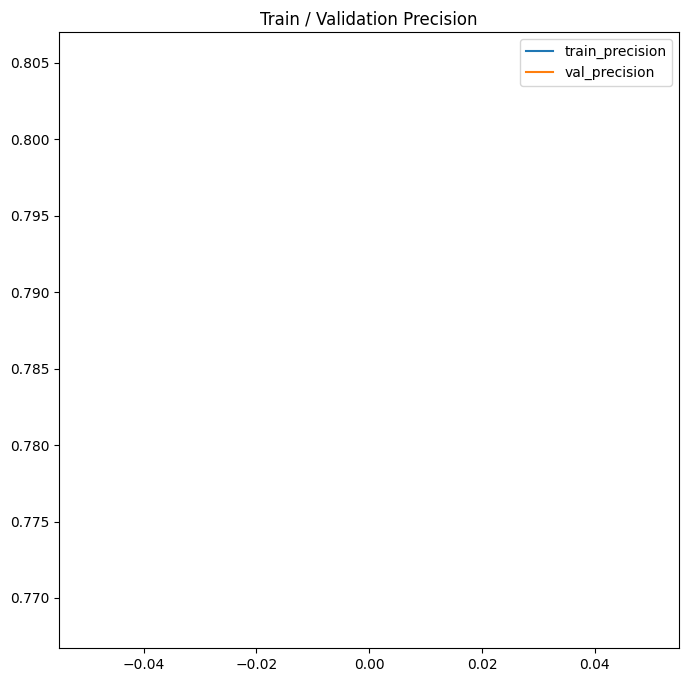

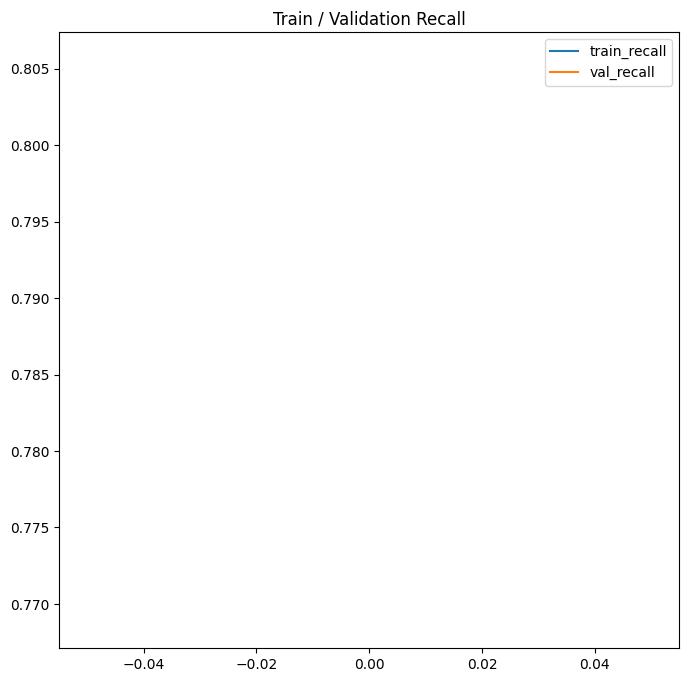

In [38]:
plot_results(log, base_history, plot_name='base_history')

In [39]:
def save_model(model, config, name):
    if not os.path.exists(f'models/{config["experiment_name"]}'):
        os.makedirs(f'models/{config["experiment_name"]}', exist_ok=True)
    full_model_path = f'models/{config["experiment_name"]}/{name}.bin'
    torch.save(model.state_dict(), full_model_path)
    return full_model_path

In [40]:
save_model(raw_model, config, base_name)

'models/default/hatexplain-bert-base-uncased-1.bin'

In [41]:
test_dataloader = torch.utils.data.DataLoader(tokenized_dataset['test'], batch_size=config['batch_size'])

In [42]:
@log_continue
def eval_results(log, results_path, model, val_dataloader, config):
    # base_model.load_state_dict(torch.load(f'models/{config["dataset_name"]}_{config["model_name"]}_{config["num_epochs"] * config["iterations"]}.bin'))
    # base_model.to(device)

    eval_results = eval_epoch(model, val_dataloader, config)

    val_loss = eval_results['loss']
    val_preds = eval_results['preds']
    cs_val_preds = eval_results['cs_preds']
    val_labels = eval_results['labels']
    val_rational_preds = eval_results['rational_preds']
    val_rational = eval_results['rational']
    val_soft_recall = eval_results['soft_rational_recall']
    val_soft_precision = eval_results['soft_rational_precision']

    if len(cs_val_preds) != 0:
        cs_val_acc = accuracy_score(val_labels, cs_val_preds)
        cs_val_f1 = f1_score(val_labels, cs_val_preds, average='macro')

    val_acc = accuracy_score(val_labels, val_preds)

    val_f1 = f1_score(val_labels, val_preds, average='macro')

    val_precision = precision_score(val_labels, val_preds, average='macro')

    val_recall = recall_score(val_labels, val_preds, average='macro')

    val_rational_jaccard = jaccard_score(val_rational, val_rational_preds, average='macro')

    val_rational_accuracy = f1_score(val_rational, val_rational_preds, average='micro')

    val_rational_f1 = f1_score(val_rational, val_rational_preds, average='macro')

    val_rational_precision = precision_score(val_rational, val_rational_preds, average='macro')

    val_rational_recall = recall_score(val_rational, val_rational_preds, average='macro')

    val_soft_rational_recall = build_hist(val_soft_recall)

    val_soft_rational_precision = build_hist(val_soft_precision)

    log.info(f'Val loss: {val_loss / len(val_dataloader)}')
    log.info(f'Val acc: {val_acc}')

    if len(cs_val_preds) != 0:
        log.info(f'CS Val acc: {cs_val_acc}')
    log.info(f'Val f1: {val_f1}')

    if len(cs_val_preds) != 0:
        log.info(f'CS Val f1: {cs_val_f1}')

    log.info(f'Val precision: {val_precision}')
    log.info(f'Val recall: {val_recall}')

    log.info(f'Val rational jaccard: {val_rational_jaccard}')
    log.info(f'Val rational accuracy: {val_rational_accuracy}')
    log.info(f'Val rational f1: {val_rational_f1}')
    log.info(f'Val rational precision: {val_rational_precision}')
    log.info(f'Val rational recall: {val_rational_recall}')
    log.info(f'Val soft rational recall: {val_soft_rational_recall}')
    log.info(f'Val soft rational precision: {val_soft_rational_precision}')

    if not os.path.exists(f'results/{config["experiment_name"]}'):
        os.makedirs(f'results/{config["experiment_name"]}', exist_ok=True)

    with open(f'results/{config["experiment_name"]}/{results_path}_eval.txt', 'w') as f:
        f.writelines(
            [
                f'Val loss: {val_loss / len(val_dataloader)}\n',
                f'Val acc: {val_acc}\n',
                f'CS Val acc: {cs_val_acc}\n' if len(cs_val_preds) != 0 else 'CS Val acc: N/A\n',
                f'Val f1: {val_f1}\n',
                f'CS Val acc: {cs_val_f1}\n' if len(cs_val_preds) != 0 else 'CS Val f1: N/A\n',
                f'Val precision: {val_precision}\n',
                f'Val recall: {val_recall}\n'
                f'Val rational jaccard: {val_rational_jaccard}\n',
                f'Val rational accuracy: {val_rational_accuracy}\n',
                f'Val rational f1: {val_rational_f1}\n',
                f'Val rational precision: {val_rational_precision}\n',
                f'Val rational recall: {val_rational_recall}\n',
                f'Val soft rational recall: {val_soft_rational_recall}\n',
                f'Val soft rational precision: {val_soft_rational_precision}\n'
            ]
        )

In [43]:
eval_results(log, base_name, raw_model, test_dataloader, config)

  0%|          | 0/72 [00:00<?, ?it/s]/var/tmp/ipykernel_10983/1785337210.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rational = torch.tensor(rational)
100%|██████████| 72/72 [00:10<00:00,  6.62it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/l

# Space Model

In [54]:
class SpaceModelWithRationalLossForSequenceClassification(torch.nn.Module):
    def __init__(
            self,
            base_model,
            n_embed=3,
            n_latent=3,
            n_concept_spaces=2,
            l1=1e-3,
            l2=1e-4,
            ce_w=1.0,
            rational_weight=0.5,
            fine_tune=True
    ):
        super().__init__()

        if fine_tune:
            for p in base_model.parameters():
                p.requires_grad_(False)

        self.device = base_model.device

        self.base_model = base_model

        self.space_model = SpaceModel(n_embed, n_latent, n_concept_spaces, output_concept_spaces=True)

        self.classifier = torch.nn.Linear(n_concept_spaces * n_latent, n_concept_spaces)

        self.l1 = l1
        self.l2 = l2
        self.ce_w = ce_w
        self.rational_weight = rational_weight

    def to(self, device):
        self.device = device
        super().to(device)
        return self

    def forward(self, input_ids, attention_mask, labels=None, hard_rationales=None, soft_rationales=None):
        embed = self.base_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        ).last_hidden_state  # (B, max_seq_len, 768)

        out = self.space_model(embed)  # SpaceModelOutput(logits=(B, n_concept_spaces * n_latent), ...)

        concept_hidden = out.logits

        logits = self.classifier(concept_hidden)

        loss = 0.0
        if labels is not None:
            raw_concept_spaces = torch.stack(
                [x.mean(2) for x in out.raw_concept_spaces]
            ).permute(1, 0, 2)
            pred_rationales = raw_concept_spaces[torch.arange(raw_concept_spaces.size(0)), labels]  # (B, max_seq_len)

            loss = self.ce_w * F.cross_entropy(logits, labels)
            loss += self.l1 * losses.inter_space_loss(out.concept_spaces, labels) + \
                    self.l2 * losses.intra_space_loss(out.concept_spaces) + \
                    self.rational_weight * F.binary_cross_entropy_with_logits(pred_rationales,
                                                                              soft_rationales.float())

        return SpaceModelForSequenceClassificationOutput(loss, logits, out.concept_spaces, out.raw_concept_spaces)

In [55]:
base_model = AutoModel.from_pretrained(MODEL_NAME)
base_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [56]:
def space_outputs_callback(outputs):
    loss, preds, logits = get_preds_from_logits(outputs)
    raw_concept_spaces = torch.stack(
        [x.mean(2) for x in outputs.raw_concept_spaces]
    ).permute(1, 0, 2)  # (B, n_concept_spaces, max_seq_len)
    return F.softmax(raw_concept_spaces[torch.arange(raw_concept_spaces.size(0)), preds], dim=-1)

In [57]:
config = {
    'experiment_name': 'no_rationales',
    'log_terminal': True,

    'dataset_name': DATASET_NAME,
    'model_name': MODEL_NAME,

    'num_labels': NUM_LABELS,
    'num_epochs': NUM_EPOCHS,
    'iterations': 1,

    'max_seq_len': MAX_SEQ_LEN,
    'batch_size': BATCH_SIZE,
    'lr': LEARNING_RATE,
    'fp16': False,
    'max_grad_norm': MAX_GRAD_NORM,
    'weight_decay': 0.01,
    'num_warmup_steps': 0,
    'gradient_accumulation_steps': 1,

    'l1': 0.1,
    'l2': 1e-5,
    'ce_w': 1.0,

    'threshold': 0.1,

    # funcs:
    'preds_from_logits_func': get_preds_from_logits,
    'model_outputs_callback': space_outputs_callback,
}

In [58]:
space_model = SpaceModelWithRationalLossForSequenceClassification(
    base_model,
    n_embed=768,
    n_latent=N_LATENT,
    n_concept_spaces=NUM_LABELS,
    l1=config['l1'],
    l2=config['l2'],
    ce_w=config['ce_w'],
    rational_weight=0,
    fine_tune=False
).to(device)

In [59]:
# space_model.load_state_dict(
#     torch.load(f'models/{config["experiment_name"]}/{DATASET_NAME}_space-{MODEL_NAME}-({N_LATENT})_{NUM_EPOCHS}.bin', map_location=device))

In [60]:
count_parameters(space_model)

109778307

In [61]:
space_name = f'{DATASET_NAME}_space-{MODEL_NAME.replace("/", "_")}-({N_LATENT})_{NUM_EPOCHS}'

In [62]:
log = get_logger(f'logs/{config["experiment_name"]}', space_name)

In [63]:
space_history = training(space_model, tokenized_dataset['train'], tokenized_dataset['validation'], log, config)

2024-04-28 17:05:27,124 - default.terminal - DEBUG - Train steps: 570
2024-04-28 17:05:27,127 - default.terminal - DEBUG - Steps per epoch: 570.75
2024-04-28 17:05:27,128 - default.terminal - INFO - Epoch: 1
  0%|          | 0/571 [00:00<?, ?it/s]/var/tmp/ipykernel_10983/1785337210.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rational = torch.tensor(rational)
100%|██████████| 72/72 [00:11<00:00,  6.53it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Jaccard is ill-defined and being se

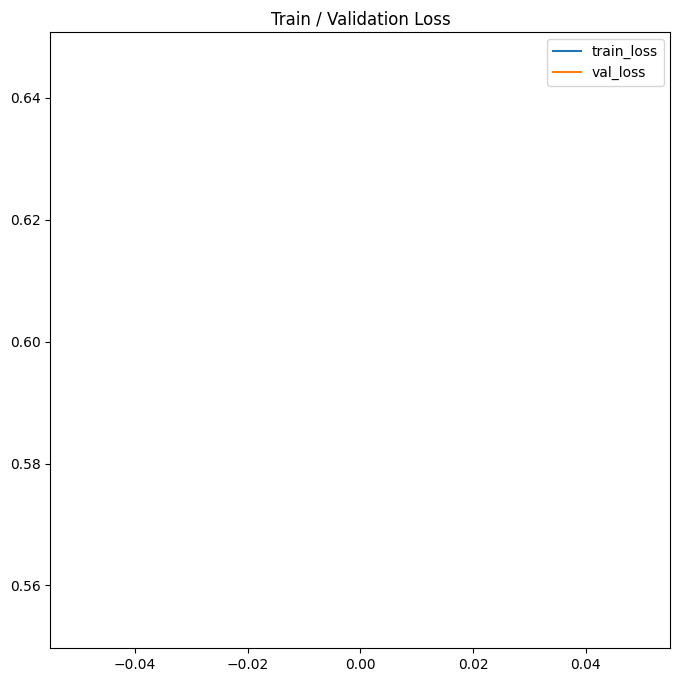

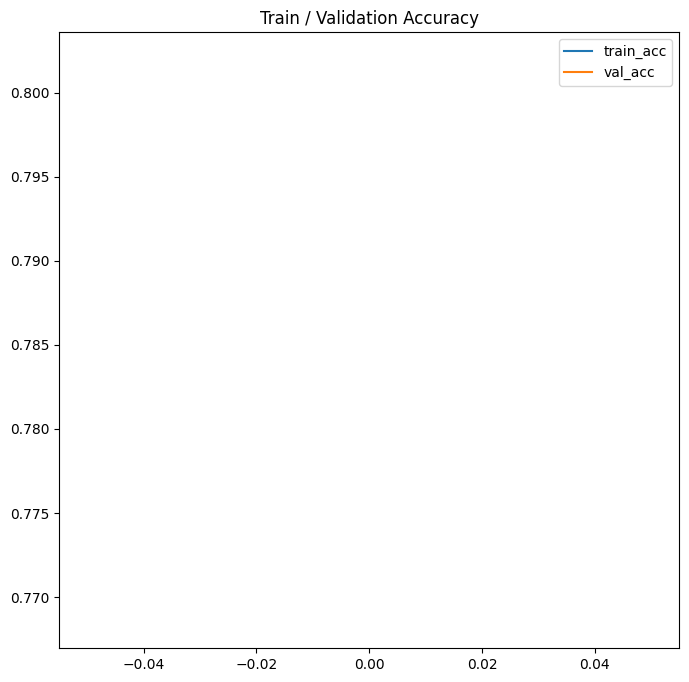

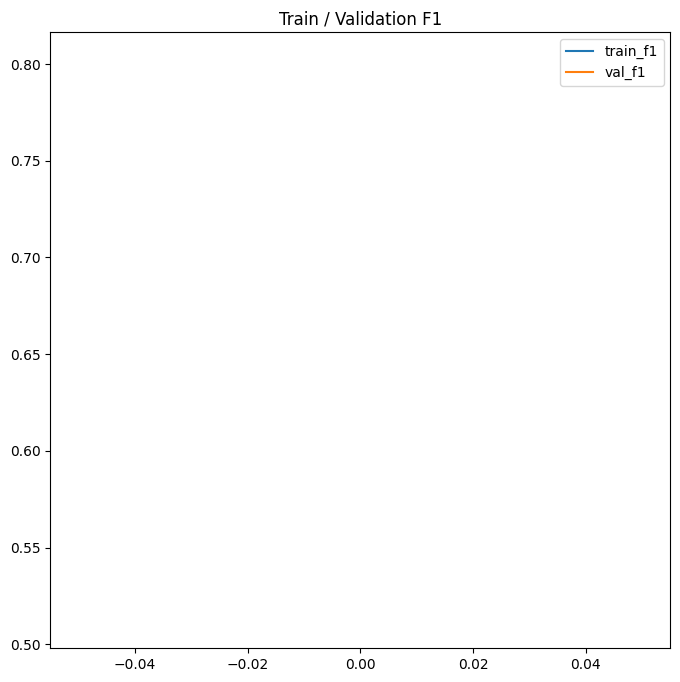

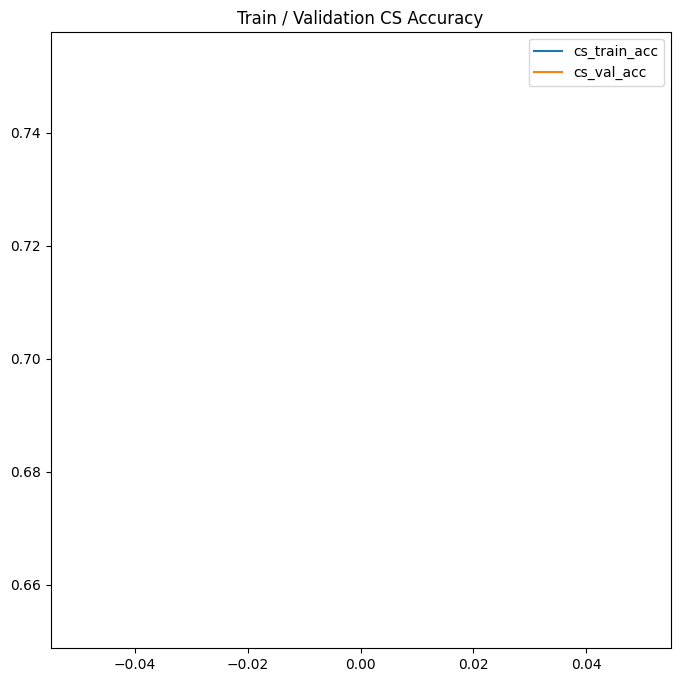

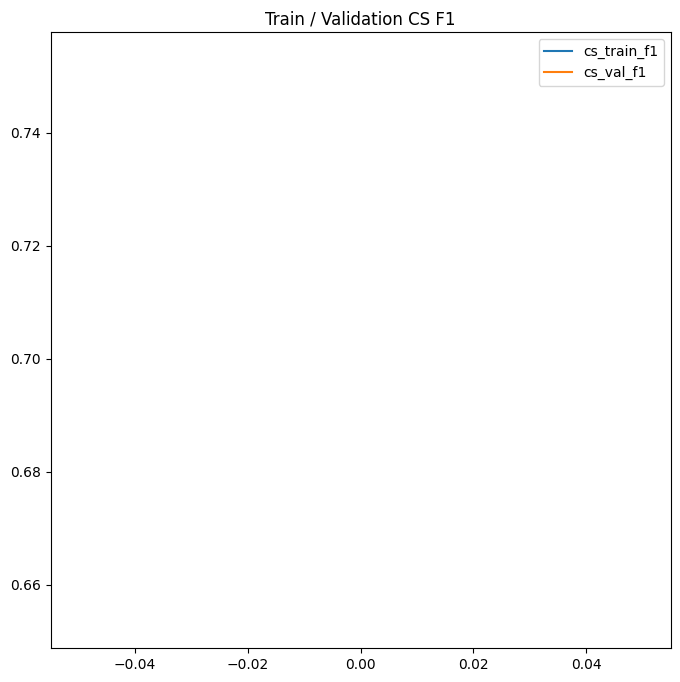

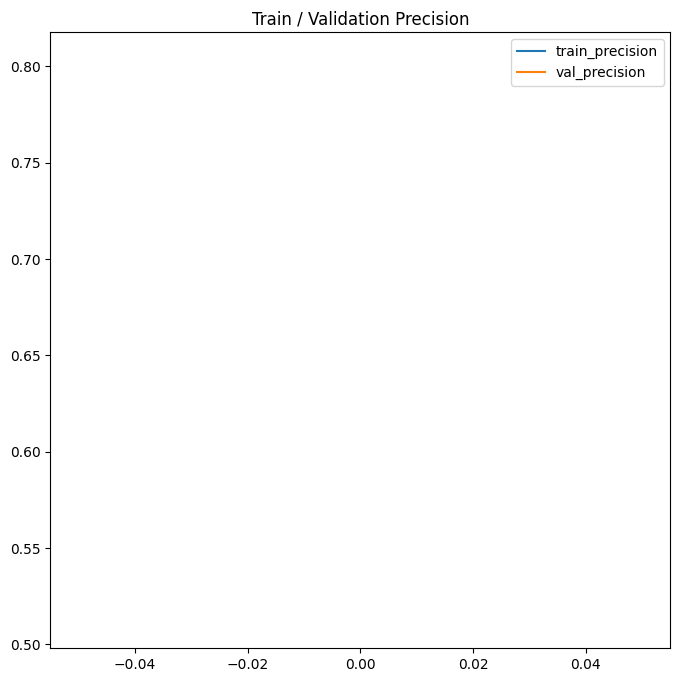

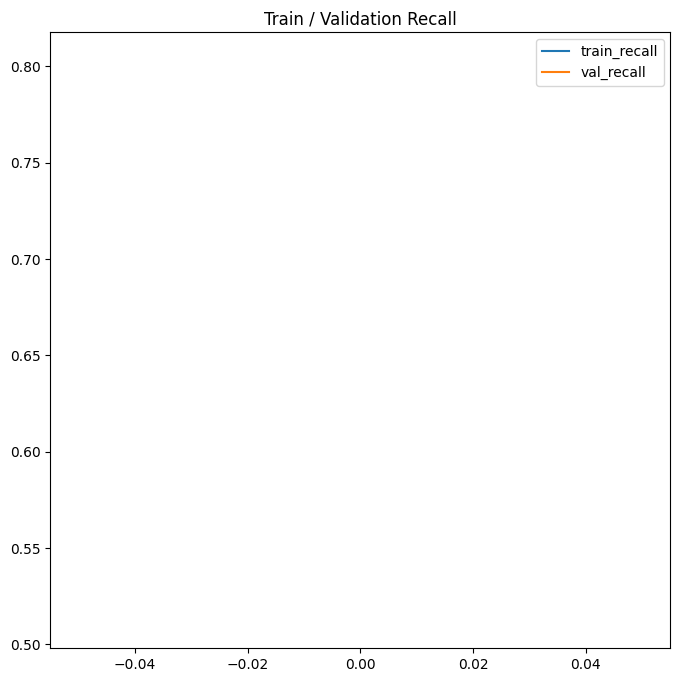

In [64]:
plot_results(log, space_history, plot_name='space_history')

In [65]:
save_model(space_model, config, space_name)

'models/no_rationales/hatexplain_space-bert-base-uncased-(128)_1.bin'

In [66]:
eval_results(log, space_name, space_model, test_dataloader, config)

  0%|          | 0/72 [00:00<?, ?it/s]/var/tmp/ipykernel_10983/1785337210.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rational = torch.tensor(rational)
100%|██████████| 72/72 [00:10<00:00,  6.57it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/l